In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
def plot_contours(means, covs, colors=None, xlim=[-10,10], ylim=[-3, 3], corr=None):
    xlist = np.linspace(xlim[0], xlim[1], 100)
    ylist = np.linspace(ylim[0], ylim[1], 100)
    X,Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    colors = colors or sns.color_palette()
    for m, c, col in zip(means, covs, colors):
        Z = multivariate_normal.pdf(XY, mean=m, cov=c)
        plt.contour(X, Y, Z, colors=[col], linestyles='solid')
    if corr is not None:
        plt.title('correlation = {:.2f}'.format(corr))
        plt.savefig('../writing/variational-objectives/figures/kl-vb-corr-{:.2f}.pdf'.format(corr), 
                    bbox_inches='tight')
    plt.show()

In [3]:
def gaussianKL(m1, c1, m2, c2):
    delta = m1 - m2
    p2 = np.linalg.inv(c2)
    return .5 * (np.trace(np.dot(c1, p2)) + np.dot(np.dot(delta, p2), delta)
                 - m1.size + np.log(np.linalg.det(c2)) - np.log(np.linalg.det(c1)))

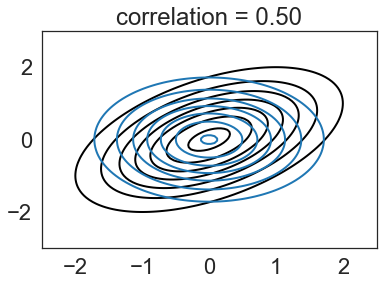

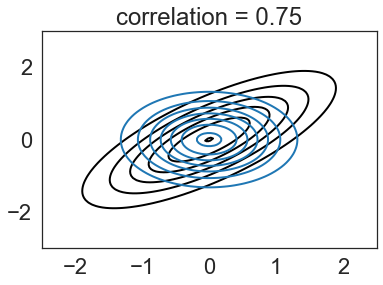

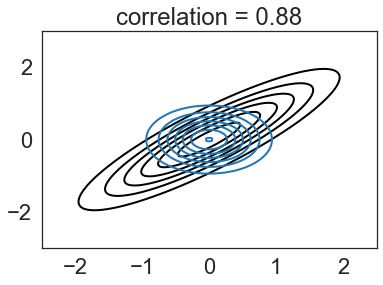

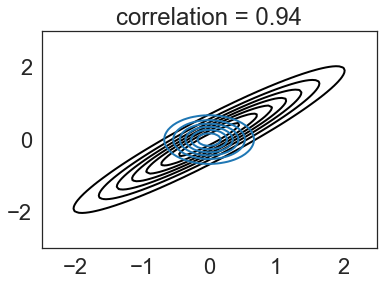

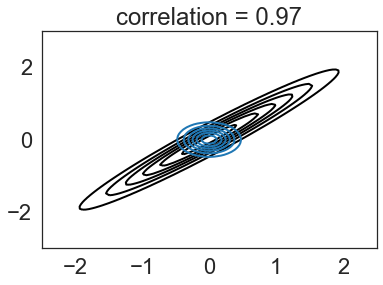

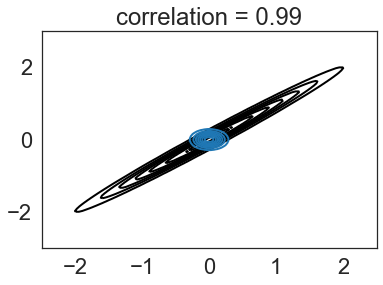

In [4]:
rhos = [.5, .75, .88, .94, .97, .99]
# rhos.reverse()
ds = np.concatenate([np.arange(2,10,2), np.arange(10,105,5,dtype=int)]) # np.arange(2,11,2,dtype=int)
df = pd.DataFrame(columns=['corr', 'd', 'KL'])
inc_df = pd.DataFrame(columns=['corr', 'd', 'KL'])
for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        def objective(logc1):
            c1 = np.diag(np.exp(logc1))
            return gaussianKL(m2, c1, m2, c2)
        res = minimize(objective, np.zeros(d), method='BFGS', jac=grad(objective))
        if d == 2:
            plot_contours(means=[m2]*2, covs=[c2, np.diag(np.exp(res.x))], 
                          colors=[(0.,0.,0.)]+sns.color_palette(),
                          xlim=[-2.5,2.5], corr=rho)
        df = df.append(dict(corr=rho, dimension=d, KL=res.fun), ignore_index=True)
        inc_kl = gaussianKL(m2, c2, m2, np.diag(np.exp(res.x)) )
        inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl), ignore_index=True)

#### First we plot KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

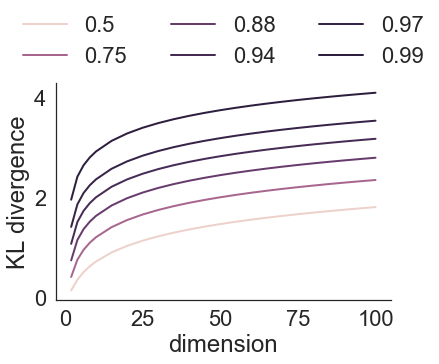

In [5]:
# sns.lineplot(data=df, x='corr', y='KL', hue='d', legend='full')
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# sns.despine()
# plt.show()
sns.lineplot(data=df, x='dimension', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-vb-d.pdf', bbox_inches='tight')
plt.show()

#### Now we plot inclusive KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

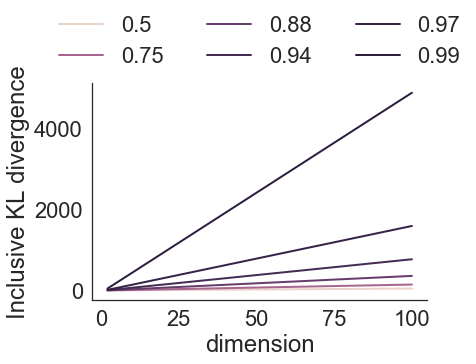

In [6]:
sns.lineplot(data=inc_df, x='dimension', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inckl-vb-d.pdf', bbox_inches='tight')
plt.show()

In [7]:
### Now at inclusive KLVI solution

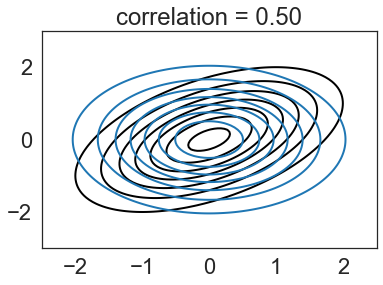

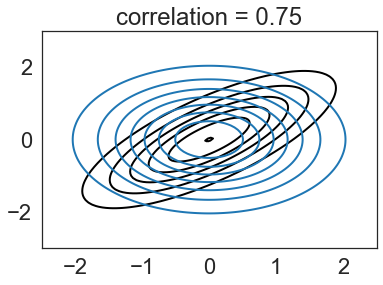

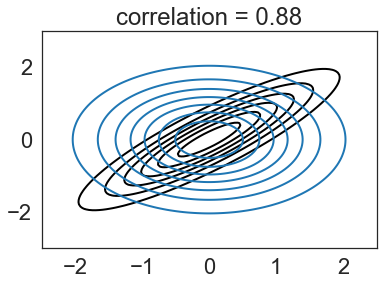

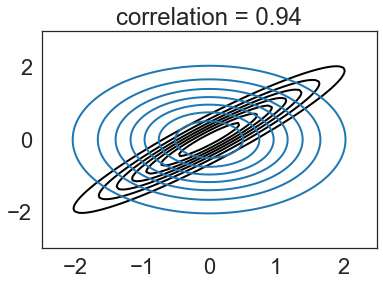

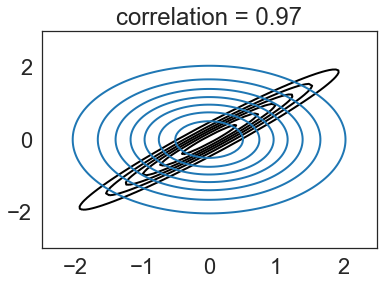

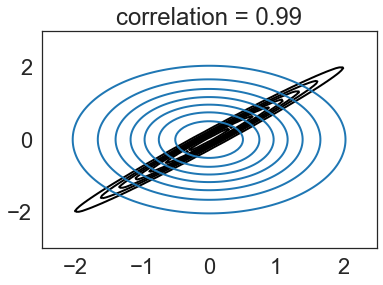

In [8]:
kl_inc_df = pd.DataFrame(columns=['corr', 'd', 'KL'])
inc_inc_df = pd.DataFrame(columns=['corr', 'd', 'KL'])
for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        def objective(logc1):
            c1 = np.diag(np.exp(logc1))
            return gaussianKL(m2, c2, m2, c1)
        res = minimize(objective, np.ones(d)*0.4, method='BFGS', jac=grad(objective))
        if d == 2:
            plot_contours(means=[m2]*2, covs=[c2, np.diag(np.exp(res.x))], 
                          colors=[(0.,0.,0.)]+sns.color_palette(),
                          xlim=[-2.5,2.5], corr=rho)
        inc_inc_df = inc_inc_df.append(dict(corr=rho, d=d, KL=res.fun), ignore_index=True)
        kl = gaussianKL( m2, np.diag(np.exp(res.x)), m2, c2 )
        kl_inc_df = kl_inc_df.append(dict(corr=rho, d=d, KL=kl), ignore_index=True)

#### Now we plot inclusive KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions

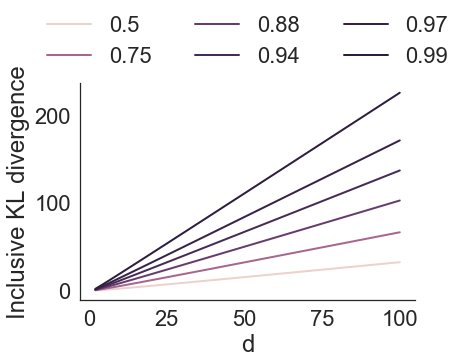

In [13]:
sns.lineplot(data=inc_inc_df, x='d', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_inckl-vb-d.pdf', bbox_inches='tight')
plt.show()

#### Now we plot KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions

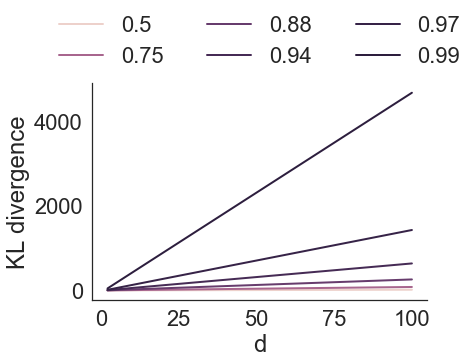

In [14]:
sns.lineplot(data=kl_inc_df, x='d', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl_at_inckl-vb-d.pdf', bbox_inches='tight')
plt.show()

In [15]:
print(inc_inc_df)

     corr      d          KL
0    0.50    2.0    0.143841
1    0.50    4.0    0.581575
2    0.50    6.0    1.106486
3    0.50    8.0    1.673976
4    0.50   10.0    2.266788
..    ...    ...         ...
133  0.99   80.0  179.718171
134  0.99   85.0  191.200788
135  0.99   90.0  202.685137
136  0.99   95.0  214.171032
137  0.99  100.0  225.658314

[138 rows x 3 columns]


In [16]:
print(kl_inc_df)

     corr      d           KL
0    0.50    2.0     0.189492
1    0.50    4.0     0.618424
2    0.50    6.0     1.036370
3    0.50    8.0     1.437133
4    0.50   10.0     1.824119
..    ...    ...          ...
133  0.99   80.0  3730.288368
134  0.99   85.0  3966.306157
135  0.99   90.0  4202.323085
136  0.99   95.0  4438.339544
137  0.99  100.0  4674.355849

[138 rows x 3 columns]


In [20]:
print(kl_inc_df.d[125], kl_inc_df.KL[125])

40.0 1842.0502150684729
